In [1]:
#libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import torch
from AbstractionModelJointPolicy import AbstractionModelJointPolicy

In [6]:
settings_name = "groundmodel_exploit_True_numepi10000_K10_L10_M2_N10_T10"
settings_filename = settings_name+".npy"
data_filename = "_trainingdata_" +settings_name+".npy"
trainedmodel_filename = "_trainingdata_" +settings_name+"_trainedmodel.pt"
loss_filename = "_trainingdata_"+settings_name+"_loggedloss.npy"

In [7]:
outdir = "output/"
# settings = np.load(outdir+settings_filename)
data = np.load(outdir+data_filename, allow_pickle=True).item()
loss_data = np.load(outdir+loss_filename)
model = np.load(outdir+trainedmodel_filename)

In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device", flush=True)

# Abstraction system
num_abs_agents = data['sys_parameters']['M']
abs_action_space_dim = data['sys_parameters']['L']  # number of discrete abstract actions
# abstract action policy network parameters
enc_hidden_dim = 256
action_space_dim = 2
state_space_dim = data['sys_parameters']['K']
num_agents = data['sys_parameters']['N']
# Initialize abstraction system model
net = AbstractionModelJointPolicy(
    state_space_dim,
    abs_action_space_dim,
    enc_hidden_dim,
    num_agents,
    num_abs_agents,
    action_space_dim=action_space_dim
)
net.to(device)
state_dict = torch.load(outdir + trainedmodel_filename)
net.load_state_dict(state_dict)
net.eval()
print(f"has {sum(p.numel() for p in state_dict.values())} parameters")

Using cpu device
has 2580 parameters


Text(0, 0.5, 'loss')

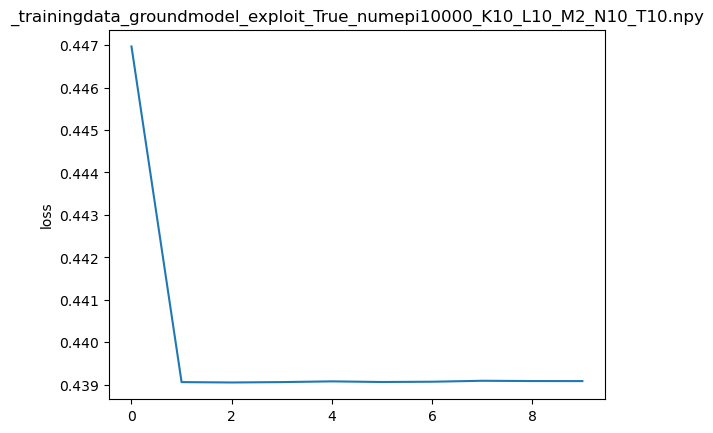

In [21]:
fig,ax=pl.subplots()
ax.plot(loss_data)
ax.set_title(data_filename)
ax.set_ylabel('loss')

Analyze datasets

In [32]:
seed_idx=0
states=np.array(data["states"][seed_idx]) #used only 1 seed
actions=np.array(data["actions"][seed_idx])
episode_times=np.array(data["times"][seed_idx])

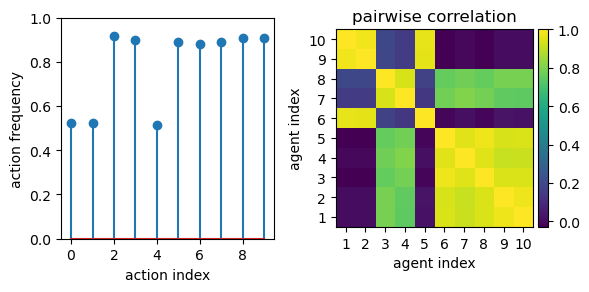

In [54]:
fig,ax=pl.subplots(1,2,figsize=(6,3))
ax[0].stem(np.mean(actions,axis=0))
ax[0].set_ylim(0,1)
ax[0].set_ylabel("action frequency")
ax[0].set_xlabel("action index")

corr_matrix = get_corr_matrix(data["actions"][0])
p=ax[1].imshow(corr_matrix, extent=[
                  0.5, num_agents+0.5, 0.5, num_agents+0.5])
ax[1].set_xticks(range(1,data['sys_parameters']['N']+1))
ax[1].set_yticks(range(1,data['sys_parameters']['N']+1))
ax[1].set_xlim(0.5, num_agents+0.5)
ax[1].set_ylim(0.5, num_agents+0.5)
ax[1].set_ylabel('agent index')
ax[1].set_xlabel('agent index')
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(p, cax=cax, orientation='vertical')
ax[1].set_title("pairwise correlation")
fig.tight_layout()

In [30]:
len(states)

1

In [41]:
from utils import get_corr_matrix

Text(0, 0.5, 'agent index')

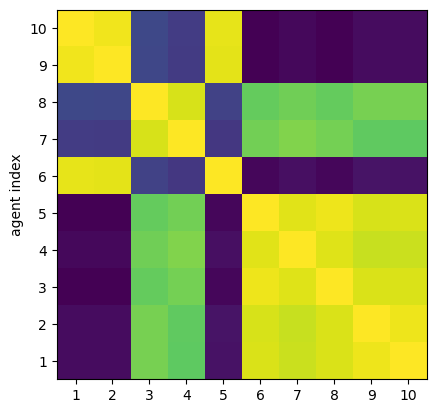